# Quantifying volume transports across the osnap section in the VIKING20X model.


## Technical preample

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import itertools as it
import seawater as sw
from scipy import interpolate

import importlib
import sys

In [3]:
# path to some plotting routines
sys.path.append(r'../../src/')

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'lines.linewidth': 1.25})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")

rho_0 = 1000.0

In [5]:
# from dask.distributed import Client

In [6]:
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=32e9)
# client

_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [7]:
# paramters

global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"
restrict_years = "20??"  # restricts to 2014 to 2018
# restrict_years = "2014"  # restricts to 2014

project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('data/interim/')
section_data_path = Path('data/interim/section-data/')

figure_path = Path('reports/figures/')

external_data_path = Path('data/external/')
section_filename = 'osnap_pos_wp.txt'

# topo_smooth = 'none','5-cell-min','9-cell-min','9-cell-mean'
topo_smooth = '5-cell-min'


## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [8]:

mesh_mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")

found 1 mesh mask files


In [9]:
mesh_mask = xr.open_dataset(mesh_mask_files[0],
#     chunks={
#         "z": 64,
#         "y": 256, "x": 1024
#     },
)

fmask = mesh_mask['fmask'].isel(z=0)

In [10]:
mesh_mask

<xarray.Dataset>
Dimensions:       (y: 2499, x: 2404, z: 46)
Dimensions without coordinates: y, x, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  float64 ...
    tmask         (z, y, x) int8 ...
    umask         (z, y, x) int8 ...
    ...            ...
    gdepv         (z, y, x) float32 ...
    gdepw_0       (z, y, x) float32 ...
    gdept_1d      (z) float64 ...
    e3t_1d        (z) float64 ...
    e3w_1d        (z) float64 ...
    depthw        (z) float64 ...
Attributes:
    history:  Mon Dec 16 12:47:29 2019: ncrename -v gdepw_1d,depthw /sfs/fs1/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

#### sections saved so read in

In [11]:
sectionU_files = list(sorted(Path(project_path / section_data_path).glob(f"v2022_05_16_01_sectionU_2???.nc")))
sectionF_files = list(sorted(Path(project_path / section_data_path).glob(f"v2022_05_16_01_sectionF_2???.nc")))


In [12]:
print(sectionU_files)
print(sectionF_files)

[PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2000.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2001.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2002.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2003.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2004.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2005.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_fluxes/data/interim/section-data/v2022_05_16_01_sectionU_2006.nc'), PosixPath('/home/jupyter-workshop007/Projects/spg_1000m_boundary_flu

In [13]:
sectionU = xr.concat(
    [xr.open_dataset(store) for store in sectionU_files],
    dim='time_counter'
)

sectionF = xr.concat(
    [xr.open_dataset(store) for store in sectionF_files],
    dim='time_counter'
)

In [14]:
# tidy up extra time_counters

sectionU["ii"]=sectionU["ii"].isel(time_counter=0, drop=True)
sectionU["jj"]=sectionU["jj"].isel(time_counter=0, drop=True)
sectionU["lat"]=sectionU["lat"].isel(time_counter=0, drop=True)
sectionU["lon"]=sectionU["lon"].isel(time_counter=0, drop=True)
sectionU["dx"]=sectionU["dx"].isel(time_counter=0, drop=True)
sectionU["dz"]=sectionU["dz"].isel(time_counter=0, drop=True)
sectionU["mask"]=sectionU["mask"].isel(time_counter=0, drop=True)

# tidy up extra time_counters

sectionF["ii"]=sectionF["ii"].isel(time_counter=0, drop=True)
sectionF["jj"]=sectionF["jj"].isel(time_counter=0, drop=True)
sectionF["lat"]=sectionF["lat"].isel(time_counter=0, drop=True)
sectionF["lon"]=sectionF["lon"].isel(time_counter=0, drop=True)
sectionF["lat"]=sectionF["lat"].isel(t=0, drop=True)
sectionF["lon"]=sectionF["lon"].isel(t=0, drop=True)

convert along-section distances to m

In [15]:
sectionU["c"]=sectionU.c/1000.0
sectionF["c"]=sectionF.c/1000.0


#### map alongtrack distances to SAM's observational alongtrack distances

In [16]:
cnew=xr.open_dataarray(project_path / interim_data_path / 'dist_grid_mapped.nc' )

In [17]:
sectionU["dist_grid"] = (("c"), cnew.data)

### Calculate geostrophic and ekman velocities

In [18]:
coriolis = 2.0 * 7.2921e-5 * np.sin(np.radians(sectionU.lat.data))
g = 9.80665

#### geostrophic relative to surface height eta

#### Ekman transport

In [19]:
ekman = -(sectionU.tau_along * sectionU.dx)/(rho_0*coriolis)

In [20]:
ekman

<xarray.DataArray (time_counter: 240, c: 5450)>
array([[  154.39734056,  -449.73411852,   144.18138528, ...,
          484.43538497,   477.50696701,   470.87526281],
       [-1010.98848078,  3866.2922263 , -1035.10351515, ...,
        -3914.06460834, -3891.15805772, -3874.80355349],
       [  905.05034044,    15.84679494,   903.77561735, ...,
          -11.63754765,   -10.63632868,   -11.00468508],
       ...,
       [-1049.35481208,  1960.42411693, -1053.07487275, ...,
        -2021.12487151, -2004.16397657, -1987.07284902],
       [ 1214.89419705,  5087.51022615,  1233.87146786, ...,
        -5218.68259148, -5179.80130538, -5142.00076911],
       [-1477.8643845 ,  4838.3776611 , -1498.67566566, ...,
        -4894.86563595, -4874.74252608, -4855.15594332]])
Coordinates:
  * c             (c) float64 3.831 7.716 11.55 ... 1.835e+04 1.836e+04
  * time_counter  (time_counter) datetime64[ns] 2000-01-16T12:00:00 ... 2019-...

#### Thermal wind

In [21]:
z = np.array([sectionU.z.data for i in range(sectionF.votemper.shape[2])]).transpose()
z = np.array([z for i in range(sectionF.votemper.shape[0])])
z.shape


(240, 46, 5451)

In [22]:
sectionF = sectionF.assign({"vodensit":(("time_counter","z","c"),sw.dens(sectionF.vosaline,sectionF.votemper,z))})

In [23]:
sectionU = sectionU.assign({"vosigma0":(("time_counter","z","c"),sw.dens(sectionU.vosaline,sectionU.votemper,0)-1000.0)})
sectionF = sectionF.assign({"vosigma0":(("time_counter","z","c"),sw.dens(sectionF.vosaline,sectionF.votemper,0)-1000.0)})

In [24]:
sectionU.vosigma0.max()

<xarray.DataArray 'vosigma0' ()>
array(27.94628906)

##### surface

In [25]:
dynheigh_surface = sectionF.vodensit.isel(z=0) * sectionF.sossheig
ddsbydx = ((dynheigh_surface.shift(c=-1)-dynheigh_surface).isel(c=slice(0,-1)))/sectionU.dx.data

In [26]:
ddsbydx

<xarray.DataArray (time_counter: 240, c: 5450)>
array([[ 6.52792532e-04, -9.65942710e-04,  5.31441142e-04, ...,
         5.07528706e-04,  7.04168631e-04,  8.62885347e-04],
       [-1.44050604e-04, -6.91473796e-05, -1.50387723e-04, ...,
        -3.00780431e-04, -2.19100853e-04, -5.77140927e-05],
       [-8.61977399e-05,  7.75669605e-05, -1.23915276e-04, ...,
        -3.36939398e-05, -8.32284930e-05, -9.80480166e-05],
       ...,
       [-1.25201819e-04, -7.83837855e-05, -1.10702959e-04, ...,
         3.76536842e-04,  2.84493547e-04,  1.85953676e-04],
       [-1.18159416e-04,  6.87075507e-05, -1.23994964e-04, ...,
         7.33227860e-05,  9.32611297e-06, -4.57191072e-05],
       [ 1.91515126e-04, -2.58210955e-04,  2.09452676e-04, ...,
         2.06340054e-04,  2.24988550e-04,  2.51172485e-04]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-16T12:00:00 ... 2019-...
    z             float32 3.047
  * c             (c) float64 0.0 0.001 0.002 0.003 ... 5.446 5.447 5.448 5.449

In [27]:
usurface = -ddsbydx*g/(rho_0*coriolis)

##### lower layers

In [28]:
# sum down from surface
dynheigh = (sectionF.vodensit * mesh_mask.e3t_1d).cumsum(dim='z',skipna=False)
# shift whole array down one level and add zero at surface
dynheigh = dynheigh.shift(z=1,fill_value=0.0)
# add to section
sectionF = sectionF.assign({"dynheigh":(("time_counter","z","c"),dynheigh.data)})
# gradient along section
dbydx = ((sectionF.dynheigh.shift(c=-1)-sectionF.dynheigh).isel(c=slice(0,-1)))/sectionU.dx.data
# normal velocity
u_tw = -dbydx*g/(rho_0*coriolis)

##### add surface and lower layers

In [29]:
utot = u_tw+usurface

In [30]:
u_barotropic = utot - u_tw

##### calculate on vertical T points

In [31]:
u_geos = utot + ((utot.shift(z=-1)-utot)*sectionU.dz.data/(2.0 * mesh_mask.e3t_1d))
u_geos_barotropic = u_barotropic + ((u_barotropic.shift(z=-1)-u_barotropic)*sectionU.dz.data/(2.0 * mesh_mask.e3t_1d))


In [32]:
sectionU = sectionU.assign({"u_geos":(('time_counter','z','c'),u_geos.data)})
sectionU = sectionU.assign({"u_geos_barotropic":(('time_counter','z','c'),u_geos_barotropic.data)})

In [33]:
u_normal_mask = (np.isnan(sectionU.u_normal) == False)

### bottom ekman layer

In [34]:
# number of levels with u_along data
levels = 46 - np.isnan(sectionU.u_along).sum(dim='z')

In [35]:
levels

<xarray.DataArray 'u_along' (time_counter: 240, c: 5450)>
array([[23, 23, 26, ..., 29, 27, 25],
       [23, 23, 26, ..., 29, 27, 25],
       [23, 23, 26, ..., 29, 27, 25],
       ...,
       [23, 23, 26, ..., 29, 27, 25],
       [23, 23, 26, ..., 29, 27, 25],
       [23, 23, 26, ..., 29, 27, 25]])
Coordinates:
  * c             (c) float64 3.831 7.716 11.55 ... 1.835e+04 1.836e+04
  * time_counter  (time_counter) datetime64[ns] 2000-01-16T12:00:00 ... 2019-...

In [36]:
Cd = 0.001
eb = 0.0025

In [37]:
speed = np.sqrt(sectionU.u_normal**2 + sectionU.u_along**2 + eb)

In [38]:
sectionU.u_along.isel(z=levels-2)

<xarray.DataArray 'u_along' (time_counter: 240, c: 5450)>
array([[-0.01354852, -0.01623199, -0.00475236, ...,  0.00118562,
         0.01232221,  0.02442099],
       [ 0.02055042,  0.00655648, -0.00266922, ..., -0.00092684,
        -0.00017331,  0.00569725],
       [ 0.075169  ,  0.01949884,  0.02303728, ..., -0.00092573,
        -0.0082934 , -0.02808997],
       ...,
       [ 0.08088014,  0.0389628 ,  0.00911475, ..., -0.00085314,
        -0.00366678, -0.02750913],
       [ 0.04931085,  0.01847776,  0.00629523, ..., -0.00118335,
         0.00274801, -0.01320805],
       [ 0.0599226 ,  0.03175831, -0.01018344, ..., -0.00053336,
         0.00926804, -0.01277384]])
Coordinates:
  * c             (c) float64 3.831 7.716 11.55 ... 1.835e+04 1.836e+04
    z             (time_counter, c) float64 734.7 734.7 ... 1.298e+03 989.2
  * time_counter  (time_counter) datetime64[ns] 2000-01-16T12:00:00 ... 2019-...

In [39]:
ekbed = ((Cd * speed * sectionU.u_along * sectionU.dx)/(coriolis)).isel(z=levels-2)

In [40]:
ekbed

<xarray.DataArray (time_counter: 240, c: 5450)>
array([[-26.34287168, -31.49937501,  -8.68664562, ...,   2.18073803,
         23.46972306,  52.27767076],
       [ 40.12908056,  12.8947561 ,  -4.79941431, ...,  -1.78628622,
         -0.31607761,  10.50718011],
       [248.0732216 ,  55.67452347,  46.19166891, ...,  -1.73440999,
        -15.9324647 , -72.08005962],
       ...,
       [293.57186442, 125.16834124,  16.69124528, ...,  -1.55453153,
         -6.74127316, -65.55439911],
       [127.8766815 ,  44.31211271,  11.37806369, ...,  -2.18420159,
          5.02876267, -26.63778029],
       [178.79856002,  84.6554845 , -18.68142018, ...,  -1.05301302,
         18.23869018, -24.22365614]])
Coordinates:
  * c             (c) float64 3.831 7.716 11.55 ... 1.835e+04 1.836e+04
    z             (time_counter, c) float64 734.7 734.7 ... 1.298e+03 989.2
  * time_counter  (time_counter) datetime64[ns] 2000-01-16T12:00:00 ... 2019-...

In [41]:
ekbed = ekbed.drop('z')

### read in Sam's observational data

In [42]:
obs = xr.open_dataset(project_path / external_data_path / 'Observed_geost_for_Alan2.nc')

## plots

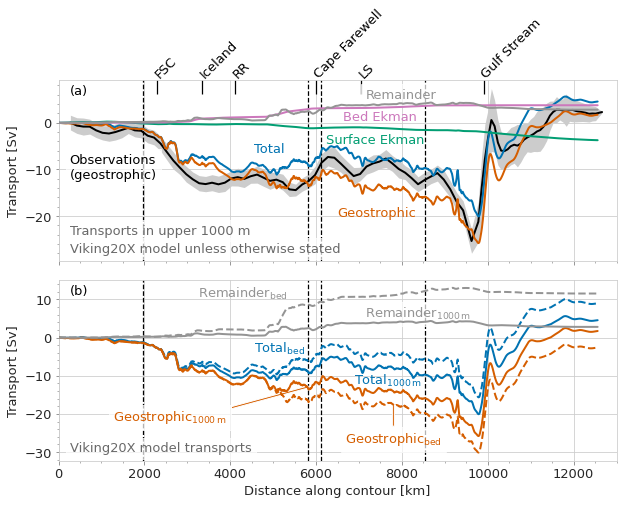

In [43]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 13})

sectionU2=sectionU.where((sectionU.z < 1000))
sectionU47=sectionU.where((sectionU.z < 1000) | (sectionU.c <= sectionU.c.isel(c=4356).data))

fig,axes = plt.subplots(2,figsize=(10,7),sharex=True,gridspec_kw={'hspace': 0.1})

ax=axes[0]

obs.geost_transport.plot(ax=ax,color='k',zorder=1,linewidth=2)
ax.fill_between(obs.dist_grid.data,obs.geost_transport_upper_bound.data,obs.geost_transport_lower_bound.data,color='k',zorder=0,alpha=0.2,linewidth=0)

total_trans = (-1*sectionU2.u_normal.where(u_normal_mask).mean(dim='time_counter')* sectionU2.dx * sectionU2.dz/1e6).sum(dim='z').cumsum(dim='c')
geost_trans = (-1*sectionU2.u_geos.where(u_normal_mask).mean(dim='time_counter')* sectionU2.dx * sectionU2.dz/1e6).sum(dim='z').cumsum(dim='c')
ekman_trans = ekman.mean(dim="time_counter").cumsum()/1e6

ekbed_trans = ekbed.mean(dim="time_counter")/1e6
ekbed_trans = ekbed_trans.where(ekbed.c <= ekbed.c.isel(c=4356).data).cumsum()

ax.plot(sectionU.dist_grid,total_trans.rolling(c=41,center=True,min_periods=11).mean(),label='total',color='C0',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,geost_trans.rolling(c=41,center=True,min_periods=11).mean(),label='geostrophic',color='C3',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,ekman_trans.rolling(c=41,center=True,min_periods=11).mean(),label='surface ekman',color='C2',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,ekbed_trans.rolling(c=41,center=True,min_periods=11).mean(),label='bottom ekman',color='C4',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,(total_trans - (geost_trans+ekman_trans+ekbed_trans)).rolling(c=41,center=True,min_periods=11).mean(),label='difference (ageostrophic)',zorder=11,color='C7',linewidth=2)


ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin,ymax)
ax.set_xlim(0,13000)
ax.vlines([2300,3350, 4100, 6000, 7050, 9900],ymin=ymax-3,ymax=ymax,color='k')
OSNAP_crossings = [1958, 5820, 6105, 8528]
ax.vlines(OSNAP_crossings,ymin=ymin,ymax=ymax,color='k',linestyle='--')
ax.text(2300-100, ymax, 'FSC', ha='left',va='bottom',rotation=45,color='k')
ax.text(3350-100, ymax, 'Iceland', ha='left',va='bottom',rotation=45,color='k')
ax.text(4100-100, ymax, 'RR', ha='left',va='bottom',rotation=45,color='k')
ax.text(6000-100, ymax, 'Cape Farewell', ha='left',va='bottom',rotation=45,color='k')
ax.text(7050-100, ymax, 'LS', ha='left',va='bottom',rotation=45,color='k')
ax.text(9900-100, ymax, 'Gulf Stream', ha='left',va='bottom',rotation=45,color='k')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('')


ax.text(0.02, 0.46, 'Observations\n(geostrophic)', horizontalalignment='left',transform=ax.transAxes,color='k',bbox=dict(facecolor='white', alpha=0.7))
ax.text(0.35, 0.6, 'Total', horizontalalignment='left',transform=ax.transAxes,color='C0')
ax.text(0.5, 0.25, 'Geostrophic', horizontalalignment='left',transform=ax.transAxes,color='C3')
ax.text(0.48, 0.65, 'Surface Ekman', horizontalalignment='left',transform=ax.transAxes,color='C2')
ax.text(0.51, 0.78, 'Bed Ekman', horizontalalignment='left',transform=ax.transAxes,color='C4')
ax.text(0.55, 0.9, 'Remainder', horizontalalignment='left',transform=ax.transAxes,color='C7',bbox=dict(facecolor='white', alpha=0.7))

ax.text(0.02, 0.15, 'Transports in upper 1000 m', horizontalalignment='left',transform=ax.transAxes,color='dimgrey',bbox=dict(facecolor='white', alpha=0.7))
ax.text(0.02, 0.05, 'Viking20X model unless otherwise stated', horizontalalignment='left',transform=ax.transAxes,color='dimgrey',bbox=dict(facecolor='white', alpha=0.7))

ax.text(0.02, 0.92, '(a)', horizontalalignment='left',transform=ax.transAxes,color='k')

ax.tick_params(which="both", bottom=True, left=True,color='grey')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())



ax=axes[1]

total_trans2 = (-1*sectionU47.u_normal.where(u_normal_mask).mean(dim='time_counter')* sectionU47.dx * sectionU47.dz/1e6).sum(dim='z').cumsum(dim='c')
geost_trans2 = (-1*sectionU47.u_geos.where(u_normal_mask).mean(dim='time_counter')* sectionU47.dx * sectionU47.dz/1e6).sum(dim='z').cumsum(dim='c')

ax.plot(sectionU.dist_grid,total_trans.rolling(c=41,center=True,min_periods=11).mean(),label='total',color='C0',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,total_trans2.rolling(c=41,center=True,min_periods=11).mean(),label='total',color='C0',zorder=11,linewidth=2,linestyle='--')
ax.plot(sectionU.dist_grid,geost_trans.rolling(c=41,center=True,min_periods=11).mean(),label='geostrophic',color='C3',zorder=11,linewidth=2)
ax.plot(sectionU.dist_grid,geost_trans2.rolling(c=41,center=True,min_periods=11).mean(),label='geostrophic',color='C3',zorder=11,linewidth=2,linestyle='--')
ax.plot(sectionU.dist_grid,(total_trans - (geost_trans+ekman_trans+ekbed_trans)).rolling(c=41,center=True,min_periods=11).mean(),label='difference (ageostrophic)',zorder=11,color='C7',linewidth=2)
ax.plot(sectionU.dist_grid,(total_trans2 - (geost_trans2+ekman_trans+ekbed_trans)).rolling(c=41,center=True,min_periods=11).mean(),label='difference (ageostrophic)',zorder=11,color='C7',linewidth=2,linestyle='--')


ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin,ymax)
ax.set_xlim(0,13000)
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Distance along contour [km]')

OSNAP_crossings = [1958,5820,6105,8528]
ax.vlines(OSNAP_crossings,ymin=ymin,ymax=ymax,color='k',linestyle='--')

tick_spacing = 2000

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# ax.set_xticklabels(rotation=45, ha='right')
# plt.xticks(rotation=45, ha='right');
# ax.ticklabel_format(axis='x', style='sci', scilimits=(3,3))

ax.text(0.35, 0.6, 'Total$_{\mathrm{bed}}$', horizontalalignment='left',transform=ax.transAxes,color='C0')
ax.text(0.53, 0.42, 'Total$_{\mathrm{1000\,m}}$', horizontalalignment='left',transform=ax.transAxes,color='C0')
# ax.text(0.53, 0.10, 'Geostrophic$_{\mathrm{bed}}$', horizontalalignment='left',transform=ax.transAxes,color='C3')
# ax.text(0.5, 0.30, 'Geostrophic$_{\mathrm{1000\,m}}$', horizontalalignment='left',transform=ax.transAxes,color='C3')
ax.text(0.25, 0.9, 'Remainder$_{\mathrm{bed}}$', horizontalalignment='left',transform=ax.transAxes,color='C7')
ax.text(0.55, 0.79, 'Remainder$_{\mathrm{1000\,m}}$', horizontalalignment='left',transform=ax.transAxes,color='C7',bbox=dict(facecolor='white', alpha=0.7))

ax.annotate("Geostrophic$_{\mathrm{1000\,m}}$", xy=(0.45,0.41),  xycoords='axes fraction',arrowprops=dict(facecolor='C3',width = 2,headwidth=2,headlength=2),
            xytext=(0.2,0.22), textcoords='axes fraction', ha='center',color='C3',bbox=dict(facecolor='white', alpha=0.7))
ax.annotate("Geostrophic$_{\mathrm{bed}}$", xy=(0.6,0.32),  xycoords='axes fraction',arrowprops=dict(facecolor='C3',width = 2,headwidth=2,headlength=2),
            xytext=(0.6,0.1), textcoords='axes fraction', ha='center',color='C3',bbox=dict(facecolor='white', alpha=0.7))

ax.text(0.02, 0.05, 'Viking20X model transports', horizontalalignment='left',transform=ax.transAxes,color='dimgrey',bbox=dict(facecolor='white', alpha=0.7))


ax.text(0.02, 0.92, '(b)', horizontalalignment='left',transform=ax.transAxes,color='k')
ax.tick_params(which="both", bottom=True,left=True,color='grey')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator()
)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator()
)



plt.savefig(project_path / figure_path / 'jonesetal2023_figure7.png',dpi=300, bbox_inches='tight')
plt.savefig(project_path / figure_path / 'jonesetal2023_figure7.pdf',dpi=300, bbox_inches='tight')


In [44]:
conda list

# packages in environment at /opt/tljh/user/envs/parcels-container_2021.09.29-09ab0ce:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
ansiwrap                  0.8.4                      py_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
basemap                   1.2.2            py39h523bb60_3    conda-forge
binutils_impl_linux-64    2.36.1     